Resolving data files:   0%|          | 0/1857 [00:00<?, ?it/s]

Train dataset size: 1484
Validation dataset size: 372
Dataset features: {'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['At-Risk-final', 'allowed-final'])}


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Class counts: Counter({1: 889, 0: 595})
Class weights: tensor([1.6693, 2.4941])


Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/372 [00:00<?, ? examples/s]

Train dataset features after transform: {'image': Image(mode=None, decode=True), 'label': ClassLabel(names=['At-Risk-final', 'allowed-final']), 'pixel_values': List(List(List(Value('float32')))), 'labels': Value('int64')}
Sample keys: ['pixel_values', 'labels']


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Vérification des données...
Keys dans un échantillon: ['pixel_values', 'labels']
Shape des pixel_values: torch.Size([3, 224, 224])
Label: 1


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.403000,0.352979,0.806452,0.786477,0.948498,0.859922
2,0.317900,0.296221,0.852151,0.834586,0.952790,0.889780
3,0.161000,0.288956,0.868280,0.862205,0.939914,0.899384
4,0.035900,0.319926,0.887097,0.902954,0.918455,0.910638
5,0.015800,0.468320,0.865591,0.929577,0.849785,0.887892
6,0.007700,0.458171,0.876344,0.919283,0.879828,0.899123
7,0.004300,0.495371,0.873656,0.922727,0.871245,0.896247
8,0.003700,0.506306,0.876344,0.919283,0.879828,0.899123
9,0.003600,0.558414,0.868280,0.925926,0.858369,0.890869
10,0.003000,0.583470,0.868280,0.925926,0.858369,0.890869


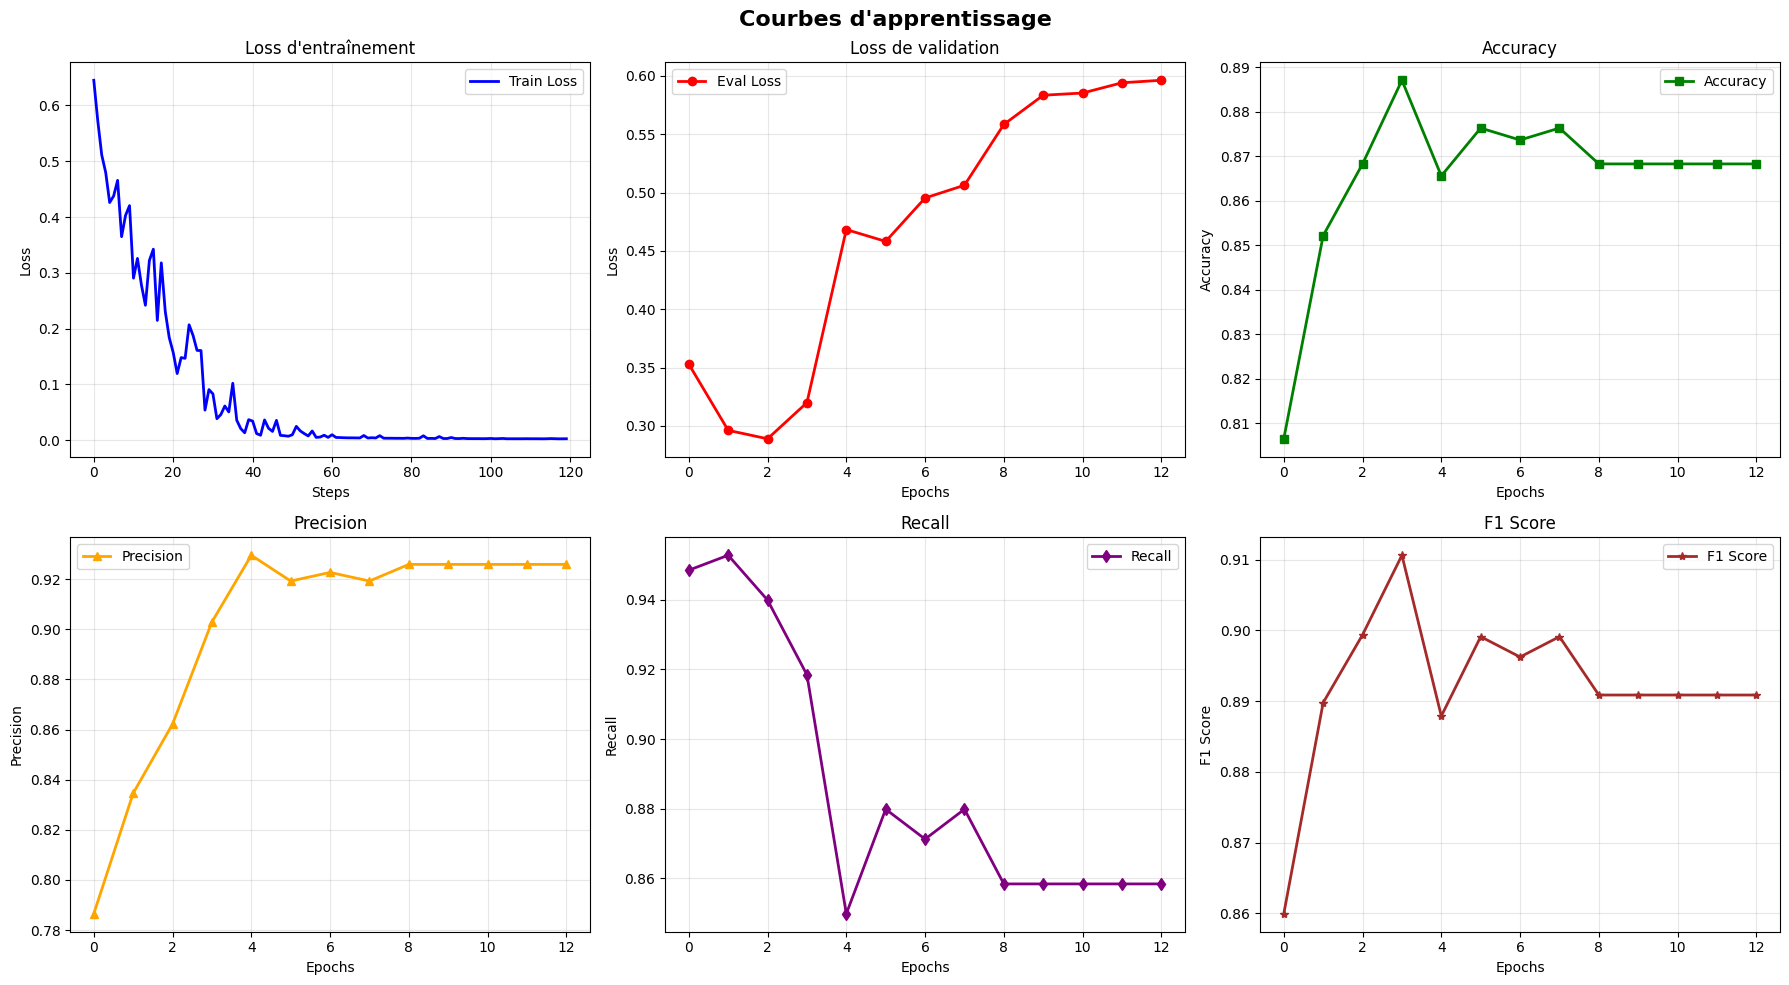


MÉTRIQUES FINALES
Best F1 Score: 0.9106
Best Accuracy: 0.8871
Final Train Loss: 0.0027
Final Eval Loss: 0.5963


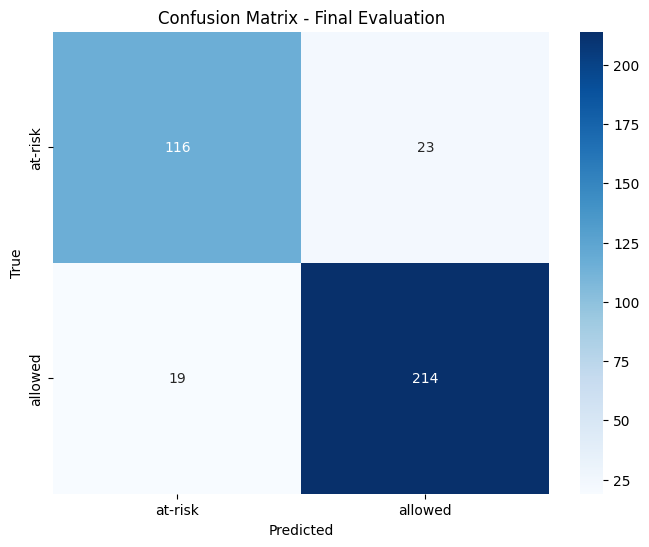


RAPPORT DÉTAILLÉ DE CLASSIFICATION
Accuracy: 0.8871
Precision: 0.9030
Recall: 0.9185
F1 Score: 0.9106
✅ Modèle sauvegardé dans /content/drive/MyDrive/saved_model2


In [ ]:

''' classification model building / training / evaluation / saving  '''



import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from torch.nn import CrossEntropyLoss
from collections import Counter
import json
import os

# 1. Load the dataset
dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/dataset")
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

train_ds, val_ds = dataset["train"], dataset["test"]

print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Dataset features: {train_ds.features}")

# 2. HuggingFace Preprocessor
checkpoint = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(checkpoint)

# 3. Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# 4. Mapping functions
def transform_train(examples):
    # Sauvegarder les labels avant de modifier le dictionnaire
    labels = examples['label']

    # Appliquer les transformations aux images
    examples['pixel_values'] = [
        train_transform(image.convert("RGB")) for image in examples['image']
    ]

    # Réassigner les labels
    examples['labels'] = labels
    return examples

def transform_val(examples):
    # Sauvegarder les labels avant de modifier le dictionnaire
    labels = examples['label']

    # Appliquer les transformations aux images
    examples['pixel_values'] = [
        val_transform(image.convert("RGB")) for image in examples['image']
    ]

    # Réassigner les labels
    examples['labels'] = labels
    return examples


# 5. Calculating class weights - BEFORE transformations

# Calculate weights BEFORE applying transformations
class_counts = Counter(train_ds['label'])
total = sum(class_counts.values())
class_weights = [total/count for count in class_counts.values()]
class_weights = torch.tensor(class_weights, dtype=torch.float)

print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

# 6. Apply transformations

train_ds = train_ds.map(transform_train, batched=True, batch_size=32)
val_ds = val_ds.map(transform_val, batched=True, batch_size=32)

# Définir le format pour PyTorch
train_ds.set_format(type='torch', columns=['pixel_values', 'labels'])
val_ds.set_format(type='torch', columns=['pixel_values', 'labels'])

print(f"Train dataset features after transform: {train_ds.features}")
print(f"Sample keys: {list(train_ds[0].keys())}")

# 7. Load the model
model = ViTForImageClassification.from_pretrained(
    checkpoint,
    num_labels=2,
    id2label={0: "at-risk", 1: "allowed"},
    label2id={"at-risk": 0, "allowed": 1},
    ignore_mismatched_sizes=True
)

# 8. Compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# 9. Custom Trainer
class WeightedTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.training_history = {
            'epoch': [],
            'train_loss': [],
            'eval_loss': [],
            'eval_accuracy': [],
            'eval_precision': [],
            'eval_recall': [],
            'eval_f1': []
        }

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        pixel_values = inputs.get("pixel_values")
        outputs = model(pixel_values=pixel_values, labels=labels)
        logits = outputs.get("logits")

        loss_fct = CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

    def log(self, logs, start_time=None):  # CORRECTION: ajout de start_time
        super().log(logs, start_time)

        # Sauvegarder les métriques d'évaluation
        if 'eval_loss' in logs:
            self.training_history['epoch'].append(len(self.training_history['epoch']) + 1)
            self.training_history['eval_loss'].append(logs.get('eval_loss'))
            self.training_history['eval_accuracy'].append(logs.get('eval_accuracy'))
            self.training_history['eval_precision'].append(logs.get('eval_precision'))
            self.training_history['eval_recall'].append(logs.get('eval_recall'))
            self.training_history['eval_f1'].append(logs.get('eval_f1'))

        # Sauvegarder la perte d'entraînement
        if 'loss' in logs:
            self.training_history['train_loss'].append(logs.get('loss'))

# 10. Training
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=13,
    logging_dir="/content/drive/MyDrive/logs2",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    logging_steps=10,
    report_to=None,
    logging_strategy="steps",
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

# Vérifier que les données sont correctes
print("Vérification des données...")
sample = train_ds[0]
print(f"Keys dans un échantillon: {list(sample.keys())}")
print(f"Shape des pixel_values: {sample['pixel_values'].shape}")
print(f"Label: {sample['labels']}")

# Entraînement
trainer.train()

# 11. Vizualisation
def plot_training_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Courbes d\'apprentissage', fontsize=16, fontweight='bold')

    # Loss curves
    axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue', linewidth=2)
    axes[0, 0].set_title('Loss d\'entraînement')
    axes[0, 0].set_xlabel('Steps')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Eval Loss
    if history['eval_loss']:
        axes[0, 1].plot(history['eval_loss'], label='Eval Loss', color='red', linewidth=2, marker='o')
        axes[0, 1].set_title('Loss de validation')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

    # Accuracy
    if history['eval_accuracy']:
        axes[0, 2].plot(history['eval_accuracy'], label='Accuracy', color='green', linewidth=2, marker='s')
        axes[0, 2].set_title('Accuracy')
        axes[0, 2].set_xlabel('Epochs')
        axes[0, 2].set_ylabel('Accuracy')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)

    # Precision
    if history['eval_precision']:
        axes[1, 0].plot(history['eval_precision'], label='Precision', color='orange', linewidth=2, marker='^')
        axes[1, 0].set_title('Precision')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # Recall
    if history['eval_recall']:
        axes[1, 1].plot(history['eval_recall'], label='Recall', color='purple', linewidth=2, marker='d')
        axes[1, 1].set_title('Recall')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    # F1 Score
    if history['eval_f1']:
        axes[1, 2].plot(history['eval_f1'], label='F1 Score', color='brown', linewidth=2, marker='*')
        axes[1, 2].set_title('F1 Score')
        axes[1, 2].set_xlabel('Epochs')
        axes[1, 2].set_ylabel('F1 Score')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # saving history
    os.makedirs("/content/drive/MyDrive/results2", exist_ok=True)
    with open('/content/drive/MyDrive/results2/training_history.json', 'w') as f:
        json.dump(history, f, indent=4)

    # Display final metrics
    print("\n" + "="*50)
    print("MÉTRIQUES FINALES")
    print("="*50)
    if history['eval_f1']:
        print(f"Best F1 Score: {max(history['eval_f1']):.4f}")
    if history['eval_accuracy']:
        print(f"Best Accuracy: {max(history['eval_accuracy']):.4f}")
    if history['train_loss']:
        print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
    if history['eval_loss']:
        print(f"Final Eval Loss: {history['eval_loss'][-1]:.4f}")

# Vizualisation
plot_training_history(trainer.training_history)

# 12. Final Evaluation
preds = trainer.predict(val_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["at-risk", "allowed"],
            yticklabels=["at-risk", "allowed"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Final Evaluation")
plt.show()

# Detailled metrics
print("\n" + "="*50)
print("RAPPORT DÉTAILLÉ DE CLASSIFICATION")
print("="*50)
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 13. Model Saving

save_dir = "/content/drive/MyDrive/saved_model2"
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

print(f"✅ Modèle sauvegardé dans {save_dir}")


In [ ]:

torch.save({
    'epoch': training_args.num_train_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': trainer.optimizer.state_dict(),
    'loss': trainer.training_history['train_loss'][-1] if trainer.training_history['train_loss'] else None,
    'class_weights': class_weights,
    'processor': processor,
    'model_config': model.config
}, '/content/drive/MyDrive/saved_model2/model_complete.pth')

# Save only the weights
torch.save(model.state_dict(), '/content/drive/MyDrive/saved_model2/model_weights.pth')

print("✅ Modèle sauvegardé en format .pth")
print("   - model_complete.pth : modèle complet avec métadonnées")
print("   - model_weights.pth : seulement les poids du modèle")

# 15. LOading exemple

print("""
# Chargement du modèle complet
checkpoint = torch.load('/content/drive/MyDrive/saved_model2/model_complete.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Ou seulement des poids
model.load_state_dict(torch.load('./content/drive/MyDrive/saved_model2/model_weights.pth'))
""")

✅ Modèle sauvegardé en format .pth
   - model_complete.pth : modèle complet avec métadonnées
   - model_weights.pth : seulement les poids du modèle

Pour charger le modèle plus tard :

# Chargement du modèle complet
checkpoint = torch.load('/content/drive/MyDrive/saved_model2/model_complete.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Ou seulement des poids
model.load_state_dict(torch.load('./content/drive/MyDrive/saved_model2/model_weights.pth'))



In [ ]:
# 14. Saving in format pt

torch.save({
    'epoch': training_args.num_train_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': trainer.optimizer.state_dict(),
    'loss': trainer.training_history['train_loss'][-1] if trainer.training_history['train_loss'] else None,
    'class_weights': class_weights,
    'processor': processor,
    'model_config': model.config,
    'training_history': trainer.training_history
}, '/content/drive/MyDrive/saved_model2/model_complete.pt')

# Saving Weights only
torch.save(model.state_dict(), '/content/drive/MyDrive/saved_model2/model_weights.pt')

print("✅ Modèle sauvegardé en format .pt")
print("   - model_complete.pt : modèle complet avec métadonnées et historique")
print("   - model_weights.pt : seulement les poids du modèle")


✅ Modèle sauvegardé en format .pt
   - model_complete.pt : modèle complet avec métadonnées et historique
   - model_weights.pt : seulement les poids du modèle
